In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('../../data/curated/yiting_cleaned_reviews.csv', parse_dates = ['Time'])
df

,Sentiment,Time,Text,processed_text
0,0,2021-06-18,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...
1,0,2021-07-07,I've been very pleased with the Natural Balanc...,please natural balance dog food dog issue dog ...
2,0,2021-06-18,"Before I was educated about feline nutrition, ...",educate feline nutrition allow cat become addi...
3,0,2021-07-07,"My holistic vet recommended this, along with a...",holistic vet recommend along brand try cat pre...
4,0,2021-01-07,I bought this coffee because its much cheaper ...,buy coffee much cheaper ganocafe organic reish...
...,...,...,...,...
5439,1,2021-02-26,"This is an okay gift box, only if you like med...",okay gift box like mediocre cheese summer saus...
5440,1,2019-12-18,It looks llike I just walked into a raw deal. ...,look llike walk raw deal item intolerably stal...
5441,1,2020-01-19,Thank god that i tasted the metal before i swa...,thank god taste metal swallow dont even get ge...
5442,1,2020-09-13,This product was very good when I began buying...,product good begin buy lately terrible taste r...


## Load in Pre-trained gloVe 

In [ ]:
# load gloVe word embeddings and create an Embeddings Dictionary
embedding_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embedding_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
test = df['processed_text'][0]
test

In [ ]:
count = 0
for word in test.split():
    embedding_vector = embedding_dictionary.get(word)
    if embedding_vector is not None:
        count += 1

In [ ]:
def get_embeddings(review):
    embedding_vector = np.zeros(shape = (100,))
    tokens = review.split()
    for word in tokens:
        embedding

In [ ]:
embedding_vector = np.zeros(shape = (100,))

# TF-IDF

In [3]:
x_train, x_test, y_train, y_test = train_test_split(df['processed_text'], df['Sentiment'], test_size = 0.2, random_state=4211)

In [4]:
vectorizer = TfidfVectorizer(max_df=0.8, sublinear_tf=True)
train_vectors = vectorizer.fit_transform(x_train)

# XGBoost

In [5]:
xgb_model = XGBClassifier()
k_folds = KFold(n_splits=5)
val_scores = cross_val_score(xgb_model, train_vectors, y_train, cv=k_folds)

In [6]:
print(f"Cross validation scores: {val_scores}") # [0.8771527  0.85304248 0.85074627 0.85189437 0.87944891]
print(f"Average CV scores: {val_scores.mean()}") # 0.8624569460390357

Cross validation scores: [0.8771527  0.85304248 0.85074627 0.85189437 0.87944891]
Average CV scores: 0.8624569460390357


In [7]:
xgb_model.fit(train_vectors, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Evaluation and Prediction

In [8]:
test_vector = vectorizer.transform(x_test)

In [9]:
x_test_predicted = xgb_model.predict(test_vector)

In [10]:
report = classification_report(y_test, x_test_predicted, output_dict=True)

print('Positive:')
print('---------')
for metric, score in report['0'].items():
    print(f'{metric}: {round(score, 3)}')
    
print('\nNegative:')
print('---------')
for metric, score in report['1'].items():
    print(f'{metric}: {round(score, 3)}')
    
print('\nOverall:')
print('--------')
print(f"accuracy: {round(report['accuracy'], 3)}")

Positive:
---------
precision: 0.892
recall: 0.948
f1-score: 0.919
support: 815

Negative:
---------
precision: 0.811
recall: 0.657
f1-score: 0.726
support: 274

Overall:
--------
accuracy: 0.875


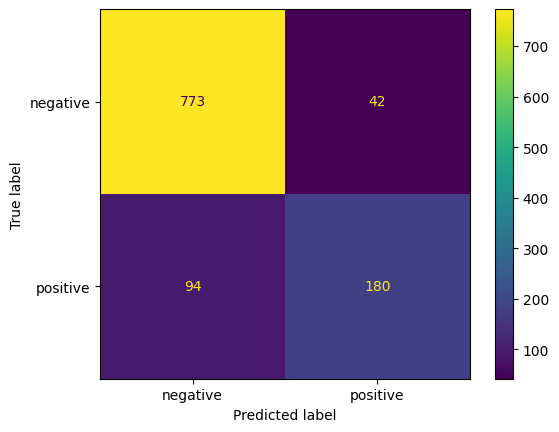

In [11]:
cm = confusion_matrix(y_test, x_test_predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['negative', 'positive'])
cm_display.plot()
plt.show()

# Save Model

In [13]:
# pickling the TF-IDF vectorizer
pickle.dump(vectorizer, open('../../model/xgboost_vectorizer.pkl', 'wb'))

# pickling the SVM Linear Classifier
pickle.dump(xgb_model, open('../../model/xgboost.pkl', 'wb'))